# Introduction


## Challenge Large Scale Machine Learning

### Authors: 
#### Kevin Elgui (kevin.elgui@gmail.com), Pascal Bianchi



### Geolocation challenge

The goal of this challenge is to develop a system which tries to perform a geolocation of connected devices within an IoT Network.

The challenge will have two phases. Please read the below information carefully.

In the first phase of the challenge, you will be provided a training dataset which contains the raw messages and their corresponding coordinates. We will also provide you a validation dataset, which only contains the raw messages. The labes of the validation set will not be provided. In this phase, you will train your system based on this data and the ranking in the challenge webpage will be based on your score obtained on the validation data.

The second phase of the challenge will start only a couple of hours before the deadline. Within this period, we will provide you the test set. You will need to run the algorithm that you developed on the first phase on this dataset and submit your predictions to the challenge webpage. Your final ranks will be determined on this dataset. Note that this phase will only last a couple of hours, which means that you will not be able to tune your algorithm on this dataset.

# The properties of the dataset:


### Training data:


The training set contains raw messages (lines) and their labels (GPS-position). There are ?? messages in this dataset. Each message is of size 1 x 20, where 20 is the number of message descriptors. For each message there is a label, a couple (latitude, longitude). 

### Validation data:



The validation set only contains raw messages. There are ?? messages in this dataset, where the format is the same as before. The labels of this dataset will not be provided. Within the first phase, your ranks will be calculated based on this dataset.

### Test data:


The test set only contains raw messages as well. There will be ?? messages in this dataset, the format is always the same. The labels of this dataset will not be provided either. This dataset will be provided only in the second phase: only a couple of hours before the challenge deadline. Your final ranks will be calculated based on this dataset.

## The performance criterion¶

The question of a suitable criterion for evaluation is tough. In practice, in order to suit industrial requirements, we evaluate your prediction throught the 90% quantile of the error vector, which is computed as follows:
$$ error = d_V(pred, true),$$ where $d_V$ is the Vincenty distance between to GPS-coordinates. Finally:

$$ criterion =  error_{(90\%)}$$
In other words, this criterion corresponds to the max error distance made by your model on $90\%$ of the test set.
The lower the score, the better the performance.

# Training Data

Raw messages: lien_to_raw_messages_train

GPS-coordinates: lien_to_label_train

# Validation Data 

Raw messages: lien_to_raw_messages_val

# Example submission

anyhow Maoist chalk numbed

In [1]:
%matplotlib inline
import numpy as np
import sys
import os
# import pandas as pd
import modin.pandas as pd
import matplotlib.pyplot as plt
import math
# from geopy.distance import vincenty

Process STDOUT and STDERR is being redirected to /tmp/raylogs/.
Waiting for redis server at 127.0.0.1:46073 to respond...
Waiting for redis server at 127.0.0.1:44270 to respond...
Starting the Plasma object store with 216.00 GB memory.


In [2]:
# adding utils to path to use scripts
os.chdir('..') ; sys.path.append(os.getcwd())
# sys.path.append('../..')

print(sys.path, os.getcwd())

['/home/infres/vcharvet/workspace/pythonProjects/geoloc-challenge/geolocenv/lib/python3.6/site-packages/ray/pyarrow_files', '/home/infres/vcharvet/workspace/pythonProjects/geoloc-challenge/notebooks', '/home/infres/vcharvet/workspace/pythonProjects/geoloc-challenge/geolocenv/lib/python3.6/site-packages', '/home/infres/vcharvet/workspace/pythonProjects/geoloc-challenge/notebooks', '/home/infres/vcharvet/workspace/pythonProjects/geoloc-challenge/geolocenv/lib/python3.6/site-packages', '', '/home/infres/vcharvet/workspace/pythonProjects/geoloc-challenge/geolocenv/lib/python36.zip', '/home/infres/vcharvet/workspace/pythonProjects/geoloc-challenge/geolocenv/lib/python3.6', '/home/infres/vcharvet/workspace/pythonProjects/geoloc-challenge/geolocenv/lib/python3.6/lib-dynload', '/usr/lib/python3.6', '/home/infres/vcharvet/workspace/pythonProjects/geoloc-challenge/geolocenv/lib/python3.6/site-packages', '/home/infres/vcharvet/workspace/pythonProjects/geoloc-challenge/geolocenv/lib/python3.6/site

## Loading and investigate the data

In [3]:
os.getcwd()


'/home/infres/vcharvet/workspace/pythonProjects/geoloc-challenge'

In [3]:
%%time
train_messages_fname = os.getcwd() + '/data/Train/Train_dataset-002.csv'
assert(os.path.exists(train_messages_fname))
# train_labels_fname = 'data/Train/label_train.csv'
# assert(os.path.exists(train_labels_fname))
val_messages_fname  = os.getcwd() + '/data/Validation/Validation_dataset.csv'
assert(os.path.exists(val_messages_fname))
# val_labels_fname = 'data/Validation/label_val.csv'

columns = ['messageid', 'latitude', 'longitude', 'did', 'time_ux', 'time_ux_client',
           'motion', 'speed', 'data_type', 'radius', 'seqnumber', 'dtid', 'nseq', 
           'rssi', 'bsid', 'snr', 'freq']

train_df = pd.read_csv(train_messages_fname, sep=',', low_memory=False)
train_df = train_df[columns]

CPU times: user 5.75 s, sys: 428 ms, total: 6.18 s
Wall time: 19.7 s


In [23]:
train_df.head()

,Unnamed: 0,messageid,latitude,longitude,did,time_ux,time_ux_client,motion,speed,data_type,radius,seqnumber,dtid,nseq,rssi,bsid,snr,freq
0,15234854,5a74b2a8e541cd137cef7232,48.969345,2.761700,5138603,1517597352000,1.517597e+12,t,0.0,gps,NaN,3197,5491a93b9336908c3b1b4c70,0,-135,8473,16.100000,868049261
1,12406538,5b216b5ae541cd3845b8c2c5,48.984978,2.361960,5132655,1528916826000,1.528917e+12,t,14.0,gps,NaN,835,5491a93b9336908c3b1b4c70,0,-134,8245,10.890000,868192913
2,9069667,5addfec9e541cd123f0bd3f5,48.837357,2.483158,5140851,1524498121000,1.524498e+12,f,0.0,gps,NaN,103,5491a93b9336908c3b1b4c70,0,-104,16082,47.549999,868134621
3,7404394,5a74bdcf12f14352d21e92a9,48.862305,2.366602,5136312,1517600207000,1.517600e+12,f,2.0,gps,NaN,570,5491a93b9336908c3b1b4c70,0,-106,3562,45.070000,868139828
4,11716433,5b00b43acf554f398fe235dd,48.752403,2.495280,5138934,1526772794000,1.526773e+12,f,1.0,gps,NaN,3079,5491a93b9336908c3b1b4c70,0,-128,3545,14.440000,868066447


In [4]:
train_labels = train_df[['latitude', 'longitude']]
# train_df.drop(columns=['latitude', 'longitude'], axis=1, inplace=True)

train_labels.head()

,latitude,longitude
0,48.969345,2.761700
1,48.984978,2.361960
2,48.837357,2.483158
3,48.862305,2.366602
4,48.752403,2.495280


### Data Visualization (requires bokeh)


In [21]:
from bokeh.io import output_notebook

output_notebook()

Loading BokehJS ...

In [22]:
## If you have bokeh installed, you can uncomment the last commands. 


from utils.plot_map import PlotMap
# PlotMap(train_labels_df)
PlotMap(train_labels)

Session output file 'gmap_.html' already exists, will be overwritten.


## Example prediction

In the following, we will train a simple regressor on toy data.

In [4]:
toy_data = pd.read_csv('data/Toy/db_toy.csv', sep=';')
toy_labels = pd.read_csv('data/Toy/labels_toy.csv', sep=';', usecols=['latitude', 'longitude'] )

### Features selection

In this example, we propose a simple feature matrix $X$ such that :

$$\begin{cases} X[i,j] &= 1 &\text{ if the $j^{th}$ basestation received the $i^{th}$ message}, \\
 X[i,j] &= 0, &\text{otherwise}. \end{cases} $$

For the project, you are free to chose other parameters for your model.

In [7]:
toy_data.head()

,messageid,latitude,longitude,did,did_hex,time_msg,time_ux,time_ux_client,motion,speed,...,radius,datepart,seqnumber,dtid,nseq,rssi,bsid_hex,bsid,snr,freq
0,5a4b36a612f1431c0bbcfe5a,49.150979,2.584248,2158065,20EDF1,2018-01-02 07:37:10,1514878630000,1514878240000,t,127.0,...,NaN,2018-01-02,536,5491a93b9336908c3b1b4c70,0,-139,F4B,3915,11.740000,868136469
1,5a4b36a612f1431c0bbcfe5a,49.150979,2.584248,2158065,20EDF1,2018-01-02 07:37:10,1514878630000,1514878240000,t,127.0,...,NaN,2018-01-02,536,5491a93b9336908c3b1b4c70,0,-137,33B8,13240,13.980000,868137053
2,5a4b36a612f1431c0bbcfe5a,49.150979,2.584248,2158065,20EDF1,2018-01-02 07:37:10,1514878630000,1514878240000,t,127.0,...,NaN,2018-01-02,536,5491a93b9336908c3b1b4c70,0,-125,33C1,13249,26.580000,868136944
3,5a4b370f12f1431c0bbda371,49.368966,2.647366,5140063,4E6E5F,2018-01-02 07:38:55,1514878735000,1514878300000,f,0.0,...,NaN,2018-01-02,3581,5491a93b9336908c3b1b4c70,0,-139,2AE9,10985,12.210000,868109404
4,5a4b3958e541cd714dedf24b,49.244820,3.094714,2154347,20DF6B,2018-01-02 07:48:40,1514879320000,1514879320000,f,0.0,...,NaN,2018-01-02,3922,5491a93b9336908c3b1b4c70,0,-100,461,1121,51.560001,868188574


In [5]:
## Please run the cell
## --------------------

features_of_interest = {"features_of_interest": ['rssi'], #, 'freq', 'speed'],
                        "target":["latitude", "longitude"]}

dict_of_gby = {'rssi': ['bsid'],
                'freq': ['bsid'],
                'latitude_bs': ['bsid'],
                'longitude_bs': ['bsid'],
                'latitude': [''],
                'longitude': [''],
                'speed': [''],
                'dtid': [''], 
                'did': [''],
              }

In [6]:
%%time
from utils.features_builder import _build_features_dict, my_parser

(feature_dict, feature_name), (target_dict, target_name)  = \
    _build_features_dict(train_df, features_of_interest)

Features of interest:  ['rssi']  
Target:  ['latitude', 'longitude']  
Nb of base stations:  159  
Nb of unique DeviceId train:  13524 
CPU times: user 6.21 s, sys: 2.42 s, total: 8.63 s
Wall time: 9.01 s


In [19]:
feature_name

{'rssi10151',
 'rssi10162',
 'rssi1092',
 'rssi10942',
 'rssi10943',
 'rssi11007',
 'rssi11850',
 'rssi11928',
 'rssi1248',
 'rssi1253',
 'rssi1264',
 'rssi1268',
 'rssi12985',
 'rssi14280',
 'rssi14589',
 'rssi14611',
 'rssi14623',
 'rssi14624',
 'rssi14731',
 'rssi14752',
 'rssi1476',
 'rssi14797',
 'rssi14816',
 'rssi15001',
 'rssi15085',
 'rssi1594',
 'rssi16079',
 'rssi16082',
 'rssi16249',
 'rssi1661',
 'rssi17098',
 'rssi17099',
 'rssi17119',
 'rssi17125',
 'rssi1743',
 'rssi1772',
 'rssi1796',
 'rssi1854',
 'rssi1859',
 'rssi1872',
 'rssi1878',
 'rssi1988',
 'rssi2189',
 'rssi2251',
 'rssi24772',
 'rssi24856',
 'rssi24908',
 'rssi24915',
 'rssi24924',
 'rssi24925',
 'rssi24928',
 'rssi24929',
 'rssi24930',
 'rssi24985',
 'rssi24990',
 'rssi24993',
 'rssi26020',
 'rssi26024',
 'rssi2605',
 'rssi26076',
 'rssi2617',
 'rssi26828',
 'rssi2707',
 'rssi2731',
 'rssi27381',
 'rssi27386',
 'rssi27412',
 'rssi27426',
 'rssi27486',
 'rssi2768',
 'rssi2776',
 'rssi2790',
 'rssi2799',
 'rs

In [8]:
import copy

In [12]:
data_copy = pd.concat((train_df, train_labels), 1)
res = {'dict_X': feature_dict, 'dict_y': target_dict}

data_it = copy.deepcopy(data_copy)

groupby_msg_id = data_it.groupby(['messageid'], sort=True)



In [18]:
groupby_msg_id['nseq'].std()

messageid
5a497a12cf554f30e846964d         NaN
5a497a24cf554f30e846c069    0.000000
5a497a2fcf554f30e846f332         NaN
5a497a4ce541cd714d45b1c5    0.000000
5a497a4dcf554f30e8472041    0.000000
5a497a62e541cd714d45dd44    0.000000
5a497a6412f1431c0b18f20c    0.000000
5a497a6ee541cd714d45f521         NaN
5a497a7be541cd714d4609f3         NaN
5a497a8ce541cd714d46259c         NaN
5a497aafcf554f30e847cc61    0.000000
5a497ac712f1431c0b199a92         NaN
5a497acbe541cd714d468fa0         NaN
5a497ad0cf554f30e84809e8         NaN
5a497ad112f1431c0b19a599    0.000000
5a497adde541cd714d46accb    0.000000
5a497af2e541cd714d46ce74    0.875261
5a497b2fcf554f30e8489c65    0.000000
5a497b39e541cd714d473f3f    0.000000
5a497b48cf554f30e848c715    0.000000
5a497b6112f1431c0b1a941e         NaN
5a497b67cf554f30e848fc62         NaN
5a497b7312f1431c0b1ab3a4         NaN
5a497b86e541cd714d47cb36         NaN
5a497b8bcf554f30e8493bde         NaN
5a497b8de541cd714d47d77b         NaN
5a497b9312f1431c0b1aed78    

In [7]:
res = my_parser(train_df, train_labels, feature_dict, target_dict, features_of_interest)


X = pd.DataFrame(res['X'].toarray(), columns=res['dict_X'])
y = pd.DataFrame(res['y'].toarray(), columns=res['dict_y'])

ValueError: too many values to unpack (expected 2)

In [15]:
print(feature_dict, X.shape)

{'rssi10744': 0, 'rssi3915': 1, 'rssi13240': 2, 'rssi17121': 3, 'rssi1241': 4, 'rssi2293': 5, 'rssi10985': 6, 'rssi1121': 7, 'rssi13249': 8, 'rssi15623': 9, 'rssi8442': 10, 'rssi2849': 11} (2680, 12)


In [16]:
X.head()

,rssi3915,rssi15623,rssi2293,rssi13249,rssi2849,rssi13240,rssi17121,rssi1121,rssi10985,rssi8442,rssi10744,rssi1241
0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,1,0,0,0
2,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,1,0


### Linear Regression

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from utils.evaluation import vincenty_df, vincenty_vec, criterion, plot_error

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=50)

In [12]:
reg = LinearRegression()
reg.fit(X_train, y_train)  

pred = pd.DataFrame(reg.predict(X_test), columns=res['dict_y'])

In [13]:
print('The criterion on the testing data : %.2f km' % criterion(pred, y_test, True))

# np.savetxt('data/Toy/pred_toy.txt', pred.values)

The criterion on the testing data : 20.23 km


/home/infres/vcharvet/workspace/pythonProjects/geoloc-challenge/geolocenv/lib/python3.6/site-packages/matplotlib/figure.py:448: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


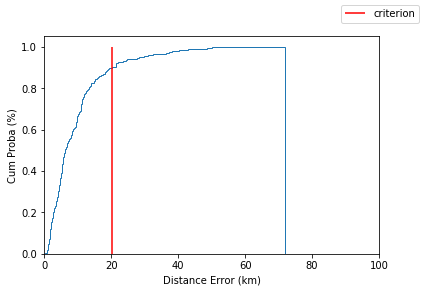

In [14]:
plot_error(pred, y_test, True)

#### Remark: 
The criterion is about 20 km. It's huge ! 

### Notation 
After having upload your file pred_test.txt on the server, you will be ranked w.r.t the criterion. 
The score which is assigned to you is computed on half of the test set. This corresponds to the public score. 
On the other half, you are assigned a private score. 

Your final score will take into account these two scores. Thus, your final rank may differ slightly from the one you see on the leader board.

#### Now it's your turn. Good luck !  :) 